# Proyecto integrado - Proyeccion de ventas para la tienda de videojuegos Ice, (2016-2017).

## Introduccion

Trabajas para la tienda online Ice que vende videojuegos por todo el mundo. Las reseñas de usuarios y expertos, los géneros, las plataformas (por ejemplo, Xbox o PlayStation) y los datos históricos sobre las ventas de juegos están disponibles en fuentes abiertas. Tienes que identificar patrones que determinen si un juego tiene éxito o no. Esto te permitirá detectar proyectos prometedores y planificar campañas publicitarias.

Delante de ti hay datos que se remontan a 2016. Imaginemos que es diciembre de 2016 y estás planeando una campaña para 2017.

Lo importante es adquirir experiencia de trabajo con datos. Realmente no importa si estás pronosticando las ventas de 2017 en función de los datos de 2016 o las ventas de 2027 en función de los datos de 2026.

El dataset contiene una columna "rating" que almacena la clasificación ESRB de cada juego. El Entertainment Software Rating Board (la Junta de clasificación de software de entretenimiento) evalúa el contenido de un juego y asigna una clasificación de edad como Adolescente o Adulto.

## Paso 1. Abre el archivo de datos y estudia la información general 

In [1]:
# Antes que nada importamos nuestras librerias
import numpy as np
import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns # para graficos de caja mas bonitos

In [2]:
df_games = pd.read_csv('/datasets/games.csv')
print(df_games.head(10))
df_games.info()

                        Name Platform  Year_of_Release         Genre  \
0                 Wii Sports      Wii           2006.0        Sports   
1          Super Mario Bros.      NES           1985.0      Platform   
2             Mario Kart Wii      Wii           2008.0        Racing   
3          Wii Sports Resort      Wii           2009.0        Sports   
4   Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing   
5                     Tetris       GB           1989.0        Puzzle   
6      New Super Mario Bros.       DS           2006.0      Platform   
7                   Wii Play      Wii           2006.0          Misc   
8  New Super Mario Bros. Wii      Wii           2009.0      Platform   
9                  Duck Hunt      NES           1984.0       Shooter   

   NA_sales  EU_sales  JP_sales  Other_sales  Critic_Score User_Score Rating  
0     41.36     28.96      3.77         8.45          76.0          8      E  
1     29.08      3.58      6.81         0.77     

Observaciones:

1) El archivo esta bien separado por comas, no hubo problemas al leerlo.
2) Nulos

       a) Name y Genre tienen 2 NaN cada una (pueden descartarse o imputarse con un placeholder “Unknown”).
   
       b) Year_of_Release: Imputar el valor faltante de año de lanzamiento y reemplazarlo por la mediana de su plataforma
   
       c) Critic_Score y Rating tienen muchos faltantes, necesitamos analizar como Imputarlos por ejemplo con la media de su plataforma y genero y en caso del Rating colocarles un 'Unknown' , por colocar algo.
   
4) La columna Year_of_Release se convirtio en tipo float64 posiblemente debido a los nulos (NaN)
5) User_Score se convirtio en tipo object porque en esta columna probablemente hay valores no numericos que estan por ser determinados ("to be determined"), deben tratarse como valores faltantes, no como texto.

## Paso 2. Prepara los datos

Ahora vamos a limpiar los datos y hacer las transformaciones necesarias para poder trabajar comodamente con nuestros datos.

1. Renombrar las columnas a minúsculas

In [3]:
df_games.columns = [col.lower() for col in df_games.columns]
print(df_games.columns)

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')


2. Convertir los datos a los tipos adecuados

year_of_release

En lugar de descartar filas con año faltante, imputamos el año mediano de la misma plataforma

In [4]:
# year_of_release
# a) Calculamos la mediana de year_of_release por platform
medianas = (
    df_games
    .groupby('platform')['year_of_release']
    .median()
    .rename('median_year')
)
df_games = df_games.merge(medianas, on='platform', how='left')

# b) Imputamos los NaN con la mediana de esa plataforma
df_games['year_of_release'] = df_games['year_of_release'].fillna(df_games['median_year'])

# c) Convertimos la columna a tipo entero
df_games['year_of_release'] = df_games['year_of_release'].astype('Int64')

# d) Eliminar columna auxiliar
df_games.drop(columns=['median_year'], inplace=True)
df_games.info()
print(df_games.head(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16715 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(5), object(5)
memory usage: 1.5+ MB
                        name platform  year_of_release         genre  \
0                 Wii Sports      Wii             2006        Sports   
1          Super Mario Bros.      NES             1985      Platform   
2             M

user_score

situacion: era tipo object, porque varias filas contenían la cadena "tbd" en lugar de un número
pandas no pudo convertilo directamente a numerico 

Reemplazamos "tbd" por NaN, porque “to be determined” indica que aún no había puntuación disponible.

In [5]:
# user_score
df_games['user_score'] = df_games['user_score'].replace('tbd', pd.NA)

# errors= coerce para que mientras este transformando los datos a tipo float, si existe un error lo pondra como NaN
df_games['user_score'] = pd.to_numeric(df_games['user_score'], errors='coerce') 

print(df_games['user_score'].head(10))
df_games.info()

0    8.0
1    NaN
2    8.3
3    8.0
4    NaN
5    NaN
6    8.5
7    6.6
8    8.4
9    NaN
Name: user_score, dtype: float64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16715 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB


Name y Genre

Ambas tienen tipo object y tienen 2 faltantes cada una

Decidi eliminar las filas porque sin nombre no puedo identificar al juego y sin genero no sabre como agruparlos en la fase de analisis.


In [6]:
df_games.dropna(subset=['name', 'genre'], inplace=True)
df_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB


rating

Esta columna tiene aproximadamente 6000 faltantes, esto indica que todavia no estaban clasificados por la ESRB.

Decidi convertir el tipo a category y dejar los NaN en blanco.
Investigando un poco descubri que el tipo category ahorra memoria porque en lugar de guardar un string multiples veces, pandas almacena cada valor UNICO una vez y asigna un codigo numerico a cada ocurrencia.

Tambien las operaciones se hacen mas eficientes por lo mismo de que trabajo con codigos numericos y no con cadenas de texto.

In [7]:
df_games['rating'] = df_games['rating'].astype('category')
print(df_games.head(10))
df_games.info()

                        name platform  year_of_release         genre  \
0                 Wii Sports      Wii             2006        Sports   
1          Super Mario Bros.      NES             1985      Platform   
2             Mario Kart Wii      Wii             2008        Racing   
3          Wii Sports Resort      Wii             2009        Sports   
4   Pokemon Red/Pokemon Blue       GB             1996  Role-Playing   
5                     Tetris       GB             1989        Puzzle   
6      New Super Mario Bros.       DS             2006      Platform   
7                   Wii Play      Wii             2006          Misc   
8  New Super Mario Bros. Wii      Wii             2009      Platform   
9                  Duck Hunt      NES             1984       Shooter   

   na_sales  eu_sales  jp_sales  other_sales  critic_score  user_score rating  
0     41.36     28.96      3.77         8.45          76.0         8.0      E  
1     29.08      3.58      6.81         0.77   

critic_score

Para mi esta columna esta grave, existen muchos juegos que no tienen reseñas formales de medios especializados que pudieran darles esta puntuacion, o tal vez no eran muy conocidos.

Los NaN reflejan la realidad de que no todos los juegos quedan evaluados por criticos.

No puedo eliminar las filas porque casi la mitad de los registros se irian, esto dañaria mucho la calidad de la muestra.

Podria rellenar con la mediana o la media de plataforma y genero, pero esto introduciria muchos datos artificiales que puede sesgar el analisis de correlacion (por ejemplo, podríamos “crear” patrones de puntuación que en realidad no existen).

Decidi dejarlo como NaN y usarlo con cuidado, consumiendo este campo solo cuando sea necesario (por ejemplo, al estudiar la relacion entre puntuacion critica y ventas, lo hare unicamente con los juegos que si tienen critic_score).

La buena noticia es que para analisis generales de ventas no necesitamos depender taaanto de la critica.

### Calcula las ventas totales (la suma de las ventas en todas las regiones) para cada juego y coloca estos valores en una columna separada.

In [8]:
# Calcular ventas totales sumando ventas en todas las regiones
df_games['total_sales'] = (
    df_games['na_sales'] +
    df_games['eu_sales'] +
    df_games['jp_sales'] +
    df_games['other_sales']
)

# Verificamos el resultado
print(df_games[['name', 'total_sales']].head(20))

                                            name  total_sales
0                                     Wii Sports        82.54
1                              Super Mario Bros.        40.24
2                                 Mario Kart Wii        35.52
3                              Wii Sports Resort        32.77
4                       Pokemon Red/Pokemon Blue        31.38
5                                         Tetris        30.26
6                          New Super Mario Bros.        29.80
7                                       Wii Play        28.91
8                      New Super Mario Bros. Wii        28.32
9                                      Duck Hunt        28.31
10                                    Nintendogs        24.67
11                                 Mario Kart DS        23.21
12                   Pokemon Gold/Pokemon Silver        23.09
13                                       Wii Fit        22.70
14                            Kinect Adventures!        21.82
15      

Son muchos millones wow 👀👀, como venden los videojuegos.

## Paso 3. Analiza los datos

cuántos juegos fueron lanzados en diferentes años?

Juegos lanzados cada año:
 year_of_release
1980       9
1981      46
1982      53
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     290
1998     386
1999     341
2000     350
2001     482
2002     829
2003     800
2004     783
2005     973
2006    1006
2007    1197
2008    1457
2009    1476
2010    1302
2011    1161
2012     653
2013     552
2014     582
2015     606
2016     502
Name: platform, dtype: int64


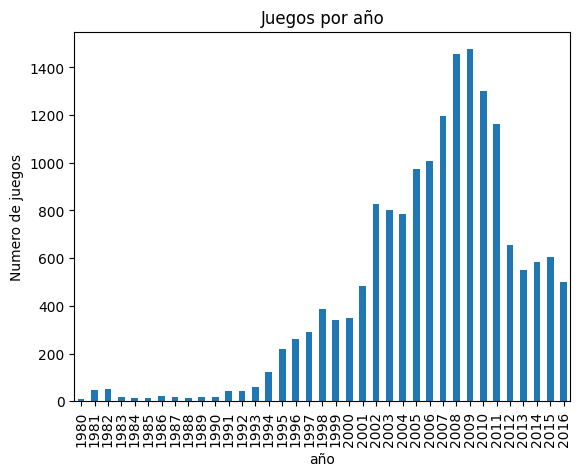

In [9]:
#print(df_games.head())
df_games_by_year = df_games.groupby('year_of_release')['platform'].count()
print("Juegos lanzados cada año:\n",df_games_by_year)
df_games_by_year.plot(kind="bar", xlabel="año", ylabel="Numero de juegos", title='Juegos por año')
plt.show()

En los 80s no eran muy conocidos los videojuegos pero apartir de ahi empezaron a hacerse mas famosos podemos ver como de 2005 a 2011 fue cuando mas se vendieron

In [10]:
# Ventas totales por plataforma
sales_by_plat = df_games.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
print("Ventas totales por plataforma:\n", sales_by_plat)


Ventas totales por plataforma:
 platform
PS2     1255.77
X360     971.42
PS3      939.65
Wii      907.51
DS       806.12
PS       730.86
GBA      317.85
PS4      314.14
PSP      294.05
PC       259.52
3DS      259.00
XB       257.74
GB       255.46
NES      251.05
N64      218.68
SNES     200.04
GC       198.93
XOne     159.32
2600      96.98
WiiU      82.19
PSV       54.07
SAT       33.59
GEN       28.35
DC        15.95
SCD        1.86
NG         1.44
WS         1.42
TG16       0.16
3DO        0.10
GG         0.04
PCFX       0.03
Name: total_sales, dtype: float64


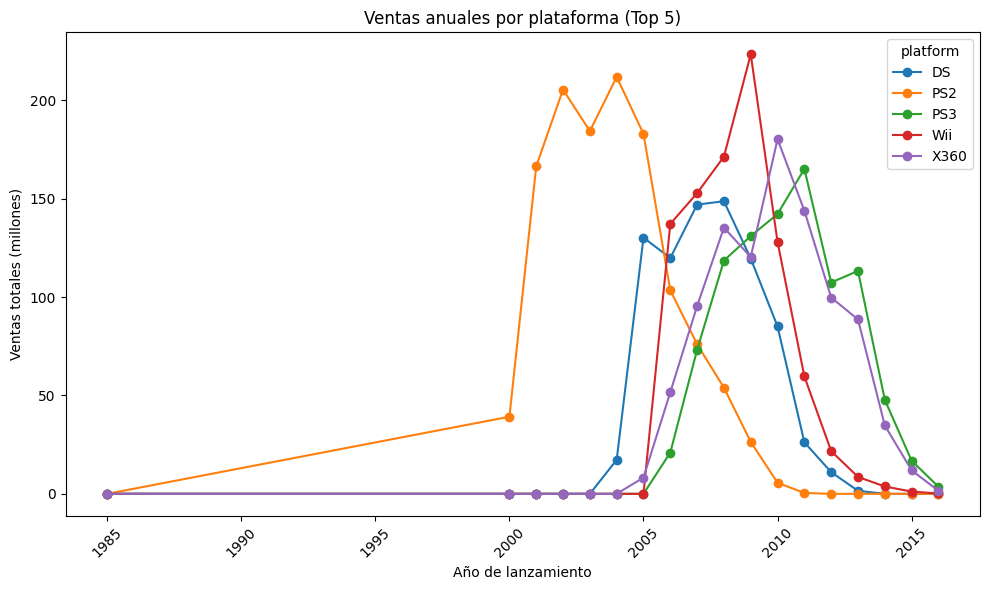

In [11]:
# Seleccionamos las 5 plataformas líderes
top5 = sales_by_plat.head(5).index.tolist()

# Agregamos ventas por año y plataforma sólo para esas top5
annual = (
    df_games[df_games['platform'].isin(top5)]
    .groupby(['year_of_release','platform'])['total_sales']
    .sum()
    .unstack('platform')
    .fillna(0)
)

# Gráfico de líneas
annual.plot(marker='o', figsize=(10,6))
plt.xlabel('Año de lanzamiento')
plt.ylabel('Ventas totales (millones)')
plt.title('Ventas anuales por plataforma (Top 5)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Cuando era niño creia que xbox y PS eran las plataformas top, pero nunca creeria que la Wii fuera tan competente tambien y que incluso les ganara en varios años.

Analisis de ciclo de vida de cada plataforma

In [12]:
# Ciclo de vida de cada plataforma
lifecycle = df_games.groupby('platform')['year_of_release'] \
                    .agg(first_year='min', last_year='max') \
                    .assign(lifetime=lambda d: d['last_year'] - d['first_year'])
print("\nCiclo de vida de plataformas:\n", lifecycle)

# Estadísticas de aparición/desaparición
avg_life = lifecycle['lifetime'].mean()
print(f"\nDuración media de vida de plataforma: {avg_life:.1f} años")

print("\nPlataformas más nuevas (primer año):")
print(lifecycle.nlargest(5, 'first_year')['first_year'])



Ciclo de vida de plataformas:
           first_year  last_year  lifetime
platform                                 
2600            1980       1989         9
3DO             1994       1995         1
3DS             2011       2016         5
DC              1998       2008        10
DS              1985       2013        28
GB              1988       2001        13
GBA             2000       2007         7
GC              2001       2007         6
GEN             1990       1994         4
GG              1992       1992         0
N64             1996       2002         6
NES             1983       1994        11
NG              1993       1996         3
PC              1985       2016        31
PCFX            1996       1996         0
PS              1994       2003         9
PS2             2000       2011        11
PS3             2006       2016        10
PS4             2013       2016         3
PSP             2004       2015        11
PSV             2011       2016         5
SA

<AxesSubplot:title={'center':'Tiempo de cada plataforma (en años)'}, xlabel='Plataforma', ylabel='Años'>

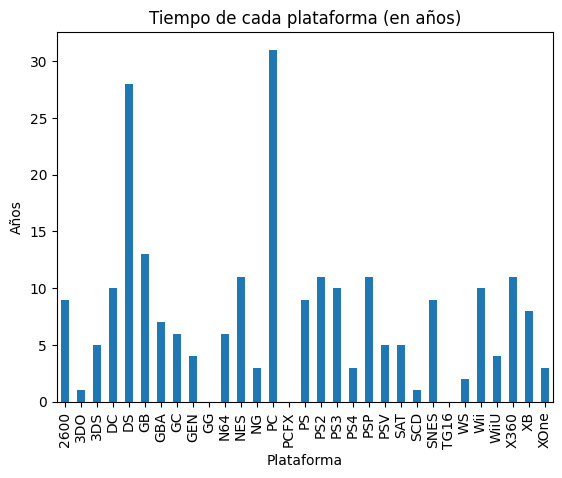

In [13]:
lifecycle['lifetime'].plot(kind="bar", xlabel="Plataforma", ylabel="Años", title="Tiempo de cada plataforma (en años)")

La duracion media de cada plataforma es de aprox 7.6 años

Nintendo DS fue la plataforma que vivio mas tiempo en nuestra muestra de datos mientras que PC es la mas antigua y al mismo tiempo la que sigue viva y sacando videojuegos cada año siendo un exito total como consola.

En cuanto al tiempo que tardan en aparecer y desaparecer las plataformas podemos poner como ejemplo a playstation que en promedio cada 6 años saco su nueva version y lo mismo para xbox, tambien podemos podemos observar como en ambas plataformas se les deja un periodo de 4 años extra a partir de que salio su nueva version y ya despues ahora si dejan de adaptar los juegos a esa antigua version.

Que periodo me combiene para hacer una proyeccion para 2017?
Necesito la fotografía más reciente del mercado.
Tomaré, pues, los últimos cinco años completos (2012-2016) de las consolas mas recientes: PS4, Xbox One, Wii U, 3DS y PSV debutan entre 2011-2013.

Desechare las consolas previas (PS3, X360, Wii) que dejaron de recibir lanzamientos hacia 2014-2016 y sus ventas anuales ya caen con fuerza.

In [14]:
df_recent = df_games.query('year_of_release >= 2012')
# print(df_recent)
# Ventas totales por plataforma (2012-2016)
sales_recent = (
    df_recent.groupby('platform')['total_sales']
    .sum()
    .sort_values(ascending=False)
)
print("Ventas totales 2012-2016 (millones):\n", sales_recent)

Ventas totales 2012-2016 (millones):
 platform
PS4     314.14
PS3     288.79
X360    236.54
3DS     195.80
XOne    159.32
WiiU     82.19
PC       62.65
PSV      49.44
Wii      35.37
DS       12.55
PSP      11.19
Name: total_sales, dtype: float64


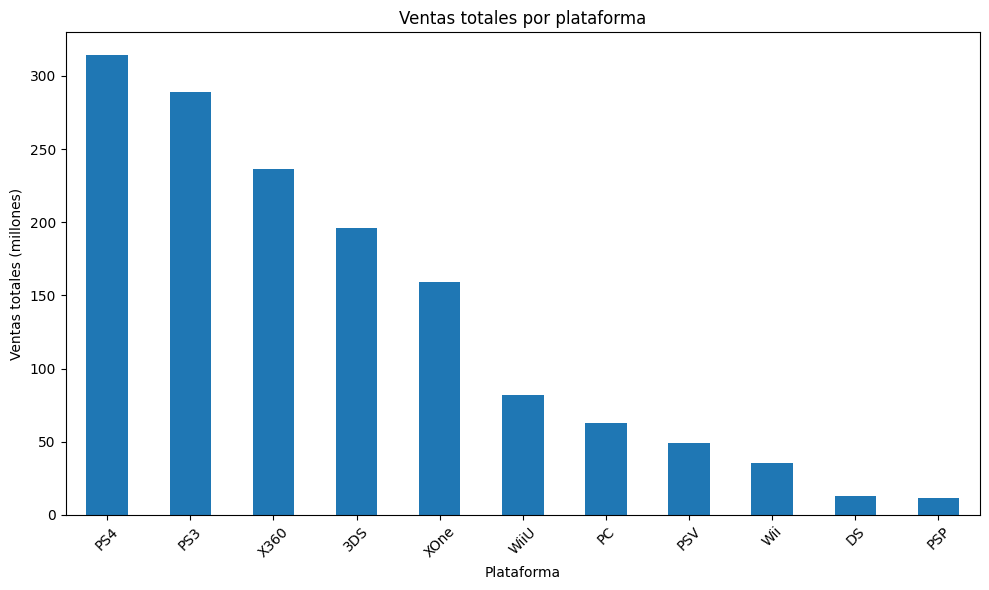

In [15]:
# Gráfico de líneas
sales_recent.plot(kind="bar", figsize=(10,6))
plt.xlabel('Plataforma')
plt.ylabel('Ventas totales (millones)')
plt.title('Ventas totales por plataforma')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Playstation tambien es mi consola favorita asi que estoy feliz de ver estos datos.
Podemos observar como el top5 son PS4, PS3, Xbox360, Nintendo 3DS y el Xbox One, todos con mas de 100 millones de ventas.


Diagrama de caja para las ventas globales de todos los juegos, desglosados por plataforma

<Figure size 1000x600 with 0 Axes>

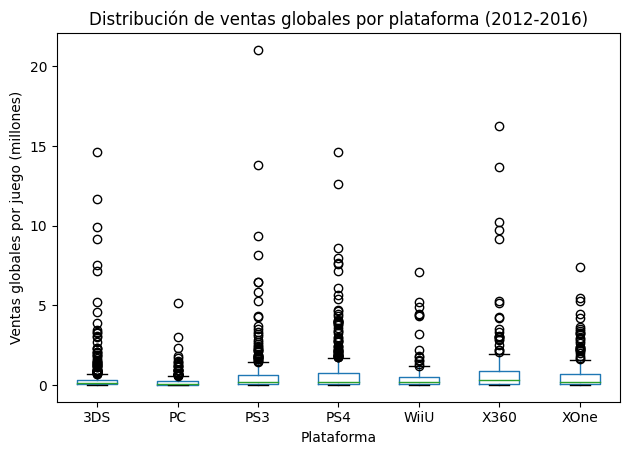

In [16]:
# Seleccionamos las plataformas con mas de 50 millones de ventas ( >50 M )
significant_plats = sales_recent[sales_recent > 50].index.tolist()

# Boxplot de ventas por juego para plataformas significativas
plt.figure(figsize=(10,6))
df_recent[df_recent['platform'].isin(significant_plats)] \
    .boxplot(column='total_sales', by='platform', grid=False, showfliers=True)
plt.title('Distribución de ventas globales por plataforma (2012-2016)')
plt.suptitle('')
plt.xlabel('Plataforma')
plt.ylabel('Ventas globales por juego (millones)')
plt.tight_layout()
plt.show()

Los valores atipicos representan a los grandes exitos de cada plataforma con mas de 1,5,15 y hasta 20 millones de copias

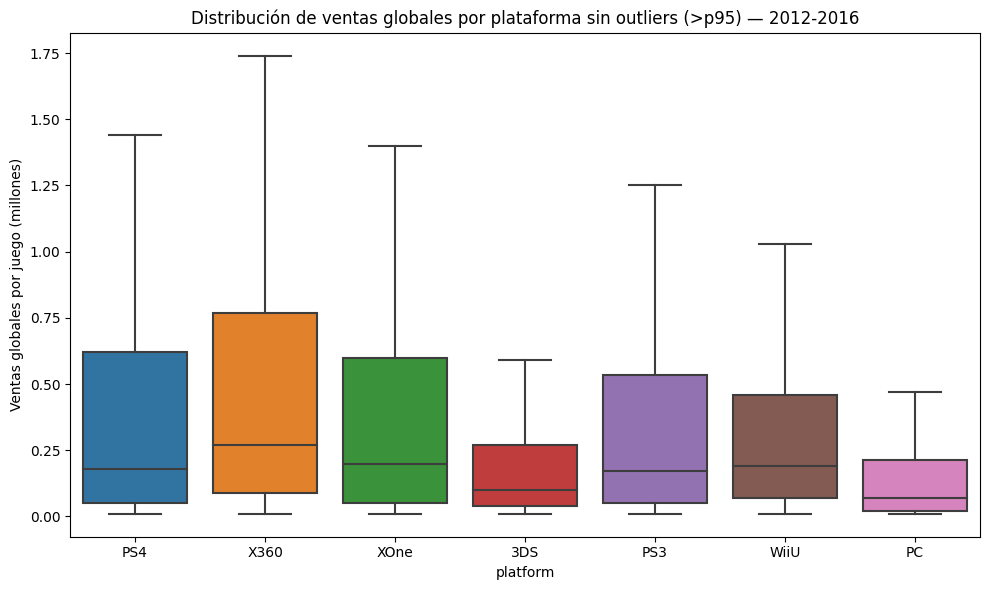

In [17]:
# Calcular límite p95 por plataforma
limite95 = (
    df_recent
      .groupby('platform')['total_sales']
      .quantile(0.95)
)

# Conservar solo los juegos por debajo o igual a su p95
mask = df_recent.apply(
    lambda row: row['total_sales'] <= limite95[row['platform']],
    axis=1
)
df_no_out = df_recent[mask & df_recent['platform'].isin(significant_plats)]

plt.figure(figsize=(10,6))
sns.boxplot(
    data=df_no_out,
    x='platform',
    y='total_sales',
    showfliers=False      # ya los quitamos
)
plt.ylabel('Ventas globales por juego (millones)')
plt.title('Distribución de ventas globales por plataforma sin outliers (>p95) — 2012-2016')
plt.tight_layout()
plt.show()

Ahora en esta distribucion sin valores atipicos podemos observar mas claramente que la mayoria de juegos venden alrededor de 0.20 millones de copias en promedio, 
pero esto no quita que hay muchos exitos que cuando son exitos la rompen bastante  👌😎 y esto beneficia mucho alas plataformas a obtener nuevos usuarios en especial si son exitos que solo se pueden jugar en esa plataforma.

### Mira cómo las reseñas de usuarios y profesionales afectan las ventas de una plataforma popular (tu elección). Crea un gráfico de dispersión y calcula la correlación entre las reseñas y las ventas. Saca conclusiones.

Vamos a analizar a la plataforma PS4

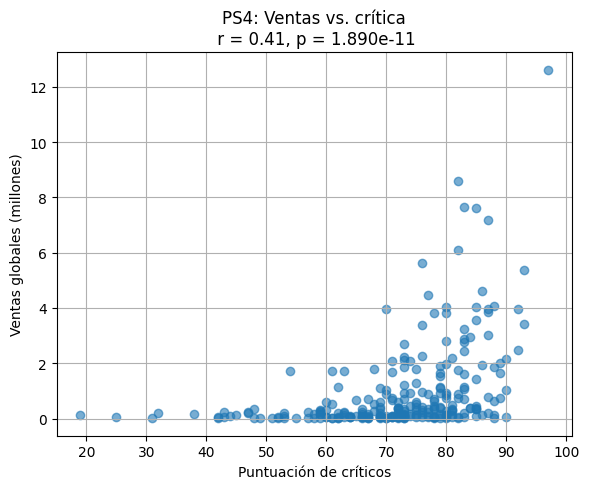

In [18]:
# Filtra solo la plataforma elegida y el periodo reciente ---
plat = 'PS4'                       # cámbialo si quieres otra
df_ps4 = df_recent[df_recent['platform'] == plat].copy()

# Ventas vs critic_score
df_crit = df_ps4.dropna(subset=['critic_score'])
r_crit, p_crit = st.pearsonr(df_crit['critic_score'], df_crit['total_sales'])

plt.figure(figsize=(6,5))
plt.scatter(df_crit['critic_score'], df_crit['total_sales'], alpha=0.6)
plt.xlabel('Puntuación de críticos')
plt.ylabel('Ventas globales (millones)')
plt.title(f'{plat}: Ventas vs. crítica\n r = {r_crit:.2f}, p = {p_crit:.3e}')
plt.grid(True)
plt.tight_layout()
plt.show()

Al parecer si parece haber una correlacion positiva entre las puntuaciones de los criticos de y las ventas de los videojuegos.

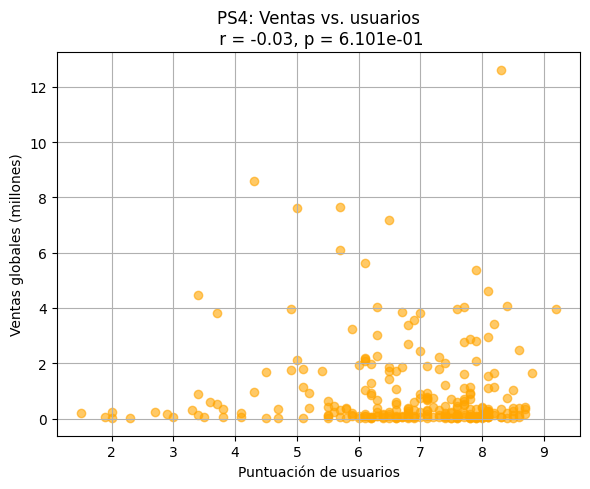

In [19]:
# ---  Ventas vs user_score --------------------------------------
df_user = df_ps4.dropna(subset=['user_score'])
r_user, p_user = st.pearsonr(df_user['user_score'], df_user['total_sales'])

plt.figure(figsize=(6,5))
plt.scatter(df_user['user_score'], df_user['total_sales'], alpha=0.6, color='orange')
plt.xlabel('Puntuación de usuarios')
plt.ylabel('Ventas globales (millones)')
plt.title(f'{plat}: Ventas vs. usuarios\n r = {r_user:.2f}, p = {p_user:.3e}')
plt.grid(True)
plt.tight_layout()
plt.show()

Nunca imagine que los usuarios fueran mas criticos que los mismos criticos jajaja, hay juegos con 2,4,6, hasta 8 millones de ventas con puntuacion de menos de 5 😟.

Pero la mayoria de juegos se encuentra entre 6 y 8 de puntuacion - 2 y 4 millones de ventas globales.

In [20]:
print(f'{plat} -> Correlación ventas–crítica:    r = {r_crit:.2f}  (p = {p_crit:.3e})')
print(f'{plat} -> Correlación ventas–usuarios:   r = {r_user:.2f}  (p = {p_user:.3e})')

PS4 -> Correlación ventas–crítica:    r = 0.41  (p = 1.890e-11)
PS4 -> Correlación ventas–usuarios:   r = -0.03  (p = 6.101e-01)


El coeficiente de correlacion de pearson de 0.41 indica una correlacion moderada entre las ventas y las puntuaciones de los criticos, esto quiere decir que entre mayor puntuacion mayores ventas.

Pero en cambio la puntuacion de los usuarios tiene poco que ver con las ventas del titulo.
El coeficiente de -0.03 indica una correlacion casi nula y no significativa.

Para 2017 podemos centrarnos en obtener buena cobertura de la crítica y entender que la percepción de los usuarios afectará más a la larga (DLCs, soporte, reputacion, comunidad e incluso puede que a las plataformas) que alas ventas iniciales.

### Teniendo en cuenta tus conclusiones compara las ventas de los mismos juegos en otras plataformas.

Necesito saber que juegos salieron para multiples plataformas
y despues analizar la distribucion de ventas por plataforma en un diagrama de caja

In [21]:
# --- Qué juegos son multi-plataforma -------------
#   (mismo Name aparece en 2+ plataformas dentro del periodo)
multi_names = (
    df_recent.groupby('name')['platform'] # agrupa por titulo
    .nunique() # cuenta cuantas plataformas distintas tiene cada titulo
    .loc[lambda s: s > 1] # filtra los que aparecen en 2 o mas plataformas
    .index # devuelve solo la lista de nombres
)

df_multi = df_recent[df_recent['name'].isin(multi_names)]

print(f"Total de títulos multi-plataforma 2012-2016: {df_multi['name'].nunique()}")


Total de títulos multi-plataforma 2012-2016: 597


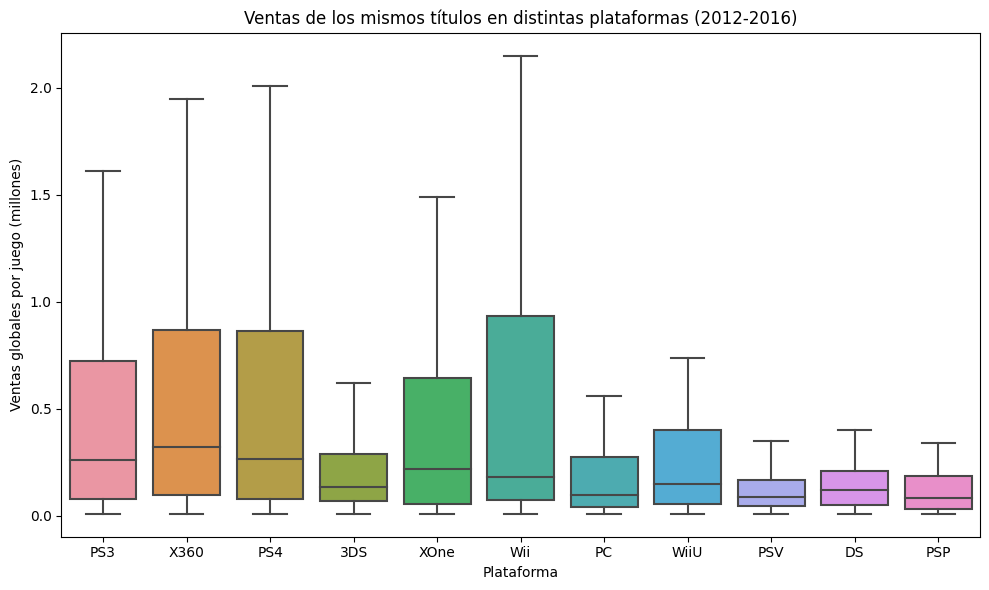

In [22]:
# --- 3. Boxplot de ventas por plataforma -------------
plt.figure(figsize=(10,6))
sns.boxplot(
    data=df_multi,
    x='platform',
    y='total_sales',
    showfliers=False # de momento nos centramos en los valores mas comunes sin outliers
)
plt.xlabel('Plataforma')
plt.ylabel('Ventas globales por juego (millones)')
plt.title('Ventas de los mismos títulos en distintas plataformas (2012-2016)')
plt.tight_layout()
plt.show()

In [23]:
summary = (
    df_multi.groupby('platform')['total_sales']
    .agg(media='mean', mediana='median', juegos='count')
    .sort_values('media', ascending=False)
)
print("\nVentas promedio de títulos multi-plataforma:")
display(summary)


Ventas promedio de títulos multi-plataforma:


,media,mediana,juegos
platform,,,
PS4,0.884335,0.265,316
X360,0.808662,0.320,269
Wii,0.711905,0.180,42
PS3,0.684453,0.260,384
XOne,0.603080,0.220,224
3DS,0.309651,0.135,86
WiiU,0.302526,0.150,95
PC,0.256374,0.100,171
DS,0.188824,0.120,17


Con estos resultados podemos decir que PS4 y Xbox One son las plataformas estrella para títulos multiplataforma, tambien el resto aporta ingresos adicionales pero con expectativas moderadas.

### Echemos un vistazo a la distribución general de los juegos por género. 

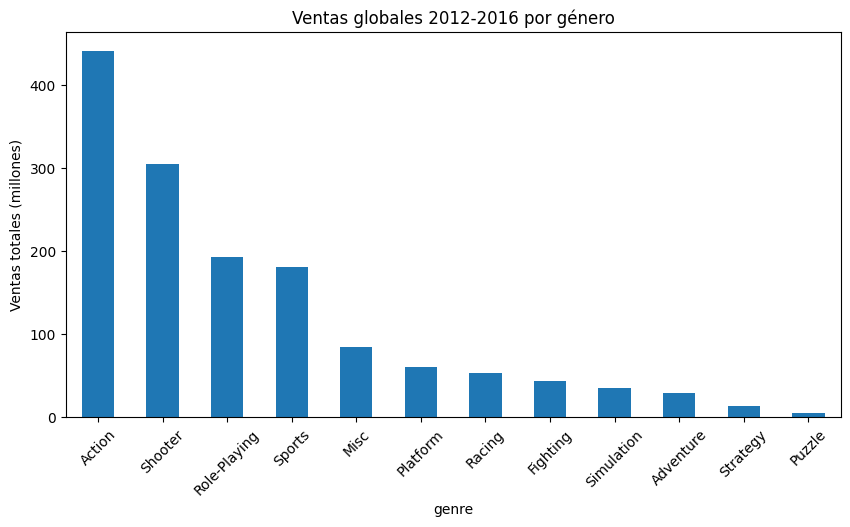

In [24]:
genre_sales = (
    df_recent
      .groupby('genre')['total_sales']
      .agg(total='sum', juegos='count')
      .assign(media_por_juego=lambda d: d['total'] / d['juegos'])
      .sort_values('total', ascending=False)
)
#print(genre_sales)

# Barras de ventas absolutas
plt.figure(figsize=(10,5))
genre_sales['total'].plot(kind='bar')
plt.ylabel('Ventas totales (millones)')
plt.title('Ventas globales 2012-2016 por género')
plt.xticks(rotation=45)
plt.show()

En primer lugar tenemos a los juegos de accion y en segundo los shooter que vienen siendo de disparos, luego nos preguntamos porque tenemos normalizamos la violencia,

No me esperaba que los juegos de rol y los de deportes tuvieran tan buenas ventas esto es genial.

Por otro lado, los generos con menos ventas son los de estrategia y puzzle, una lastima para lo buenos que son para la mente y para los niños.

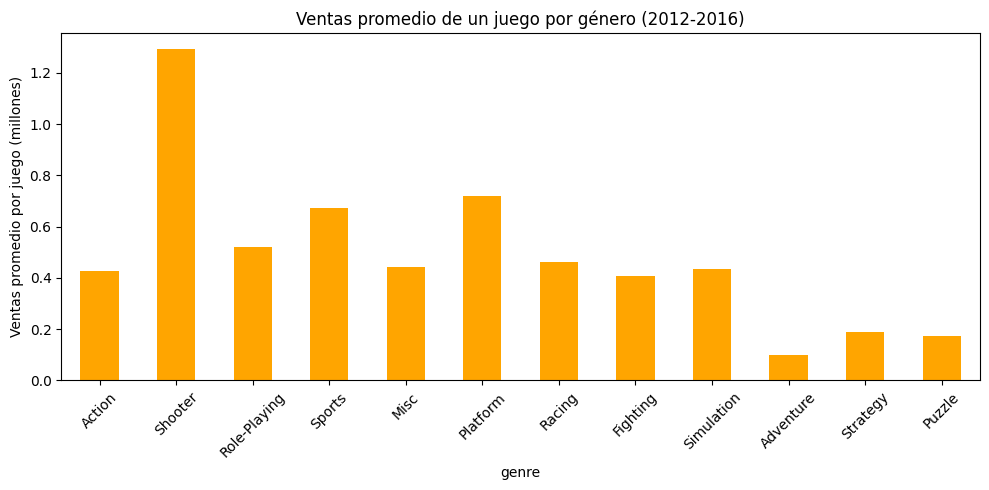

,total,juegos,media_por_juego
genre,,,
Action,441.52,1032,0.427829
Shooter,304.80,236,1.291525
Role-Playing,193.09,372,0.519059
Sports,181.09,269,0.673197
Misc,85.04,192,0.442917
Platform,61.00,85,0.717647
Racing,53.59,116,0.461983
Fighting,44.49,109,0.408165
Simulation,35.61,82,0.434268


In [25]:
# Barras de ventas medias por juego
plt.figure(figsize=(10,5))
genre_sales['media_por_juego'].plot(kind='bar', color='orange')
plt.ylabel('Ventas promedio por juego (millones)')
plt.title('Ventas promedio de un juego por género (2012-2016)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

display(genre_sales)

Los generos mas rentables parecen ser los generos Shooter (1.29 M) y Sports (0.67 M)
pocos lanzamientos concentran grandes ventas.

Tambien Platform sorprende con 0.72 M de media, pero su tamaño absoluto es menor (85 juegos).

Normalmente impulsado por series como “Mario”, “Rayman” y remakes 2D.

Action es la que mas vende pero esta muy saturado.

## Paso 4. Crea un perfil de usuario para cada región

### Para cada región (NA, UE, JP) determina:

Las cinco plataformas principales. Describe las variaciones en sus cuotas de mercado de una región a otra.

In [26]:
reg_cols = {'na_sales':'NA', 'eu_sales':'EU', 'jp_sales':'JP'}
top_platforms_region = {} # guardará la lista top-5 por región

summary_tables = [] # lista de DataFrames para mostrar tablas

for col, region in reg_cols.items():
    # Ventas totales por plataforma en la región
    regional_sales = (
        df_recent.groupby('platform')[col] # agrupa por plataforma y toma la columna regional
                 .sum() # suma las ventas de todos los juegos
                 .sort_values(ascending=False)
    )
    total_region = regional_sales.sum() # suma total mercado (denominador para cuotas)

    # Seleccionamos las 5 plataformas más vendidas
    top5 = regional_sales.head(5)
    top_platforms_region[region] = top5.index.tolist() # guarda para el gráfico apilado
    
    # Construir tabla top-5 con porcentaje de cuota
    table = (
        top5.to_frame(name='sales_m') # convierte a DataFrame
            .assign(share_pct=lambda d: 100*d['sales_m']/total_region) # cuota %
            .reset_index() # reseteamos el indice para que no haya indices vacios
            .rename(columns={'platform':'platform_'+region})
    )
    summary_tables.append(table)
    
    # Mostrar resultados:
    print(f"\n{region} — Top-5 plataformas (2012-2016)")
    display(table)


NA — Top-5 plataformas (2012-2016)


,platform_NA,sales_m,share_pct
0,X360,140.05,23.660292
1,PS4,108.74,18.370726
2,PS3,103.38,17.465198
3,XOne,93.12,15.731856
4,3DS,56.15,9.486079



EU — Top-5 plataformas (2012-2016)


,platform_EU,sales_m,share_pct
0,PS4,141.09,27.824012
1,PS3,106.86,21.073598
2,X360,74.52,14.695906
3,XOne,51.59,10.173937
4,3DS,42.85,8.450343



JP — Top-5 plataformas (2012-2016)


,platform_JP,sales_m,share_pct
0,3DS,87.84,45.583809
1,PS3,35.29,18.313441
2,PSV,21.11,10.954852
3,PS4,15.96,8.282304
4,WiiU,13.01,6.751427


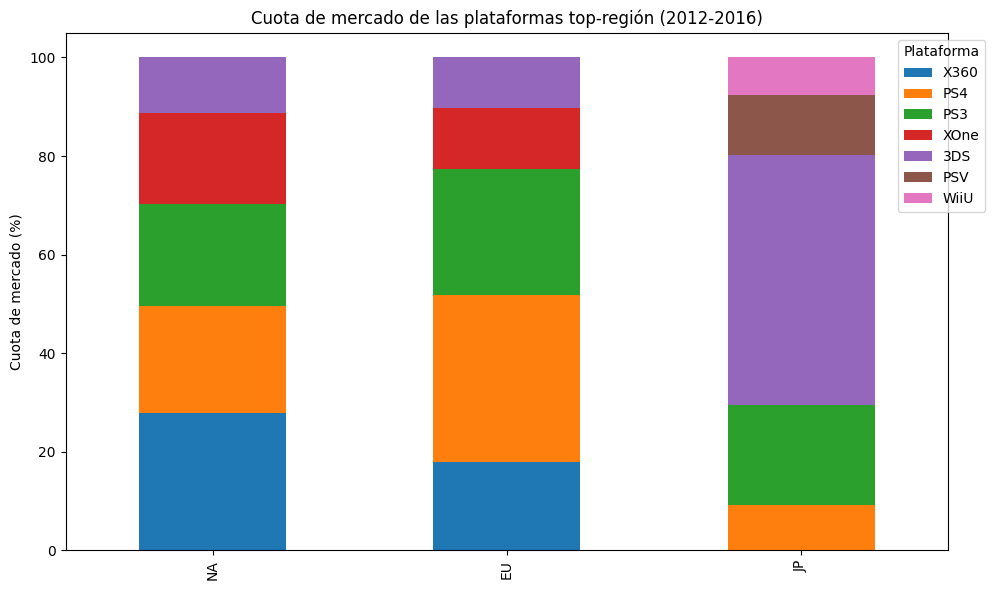

In [27]:
# --- Comparar las cuotas en un gráfico apilado ---
df_plot = pd.DataFrame(index=reg_cols.values()) # filas: NA, EU, JP

for region, top5 in top_platforms_region.items():
    for plat in top5:                        # algunas repiten, otras no
        # suma ventas de esa plataforma en esa región
        df_plot.loc[region, plat] = (
            df_recent.loc[df_recent['platform'] == plat, f"{region.lower()}_sales"].sum()
        )

# Convertimos a % de cuota (fila / suma de la fila)
df_plot = df_plot.div(df_plot.sum(axis=1), axis=0)*100

# Grafica de barras apilada para mostrar cómo se reparte el pastel por región
df_plot.plot(kind='bar', stacked=True, figsize=(10,6))
plt.ylabel('Cuota de mercado (%)')
plt.title('Cuota de mercado de las plataformas top-región (2012-2016)')
plt.legend(title='Plataforma', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

1) Xbox es la plataforma dominante en NA
2) PS4 en EU
3) Nintendo 3DS en JP
4) Al parecer Xbox ni aparece en las ventas de Japon pero en cambio la WiiU y la PSVita si.
5) Europa y Estados unidos comparten las mismas cuotas pero solo cambia que en eu es mas famoso el xbox y en europa lo es el playstation.

### Para cada región (NA, UE, JP) determina los 5 géneros principales.

In [28]:
top_genres_by_reg = {}   # guardará nombres top-5
tables = []              # lista de tablas para mostrar

for col, region in reg_cols.items():
    # 1. Ventas totales por género en la región
    sales_gen = (
        df_recent.groupby('genre')[col]
                 .sum()
                 .sort_values(ascending=False)
    )
    total_region = sales_gen.sum()           # denominador para cuotas

    # 2. Top-5 géneros
    top5 = sales_gen.head(5)
    top_genres_by_reg[region] = top5.index.tolist()

    # 3. Tabla con cuota %
    table = (
        top5.to_frame(name='sales_m')
            .assign(share_pct=lambda d: 100 * d['sales_m'] / total_region)
            .reset_index()
            .rename(columns={'genre':f'genre_{region}'})
    )
    tables.append(table)

    print(f'\n{region} — Top-5 géneros 2012-2016')
    display(table)


NA — Top-5 géneros 2012-2016


,genre_NA,sales_m,share_pct
0,Action,178.02,30.075010
1,Shooter,144.81,24.464455
2,Sports,81.53,13.773821
3,Role-Playing,64.11,10.830856
4,Misc,38.19,6.451885



EU — Top-5 géneros 2012-2016


,genre_EU,sales_m,share_pct
0,Action,159.53,31.460519
1,Shooter,113.49,22.381084
2,Sports,69.09,13.625069
3,Role-Playing,48.58,9.580342
4,Racing,27.29,5.381794



JP — Top-5 géneros 2012-2016


,genre_JP,sales_m,share_pct
0,Role-Playing,65.54,34.011417
1,Action,52.80,27.400104
2,Misc,12.86,6.673586
3,Simulation,10.41,5.402180
4,Fighting,9.44,4.898806


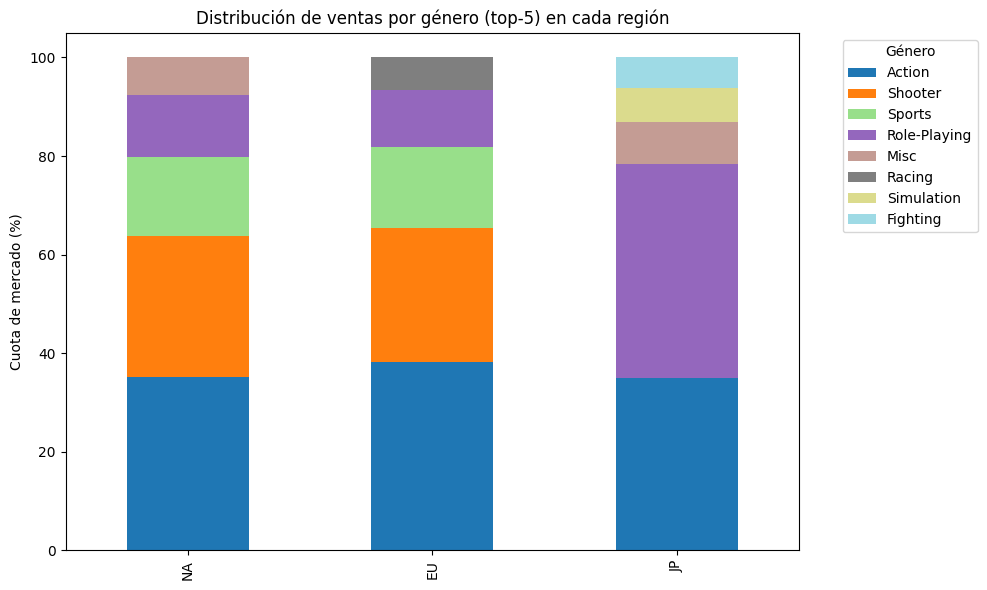

In [29]:
# 4) Construir DataFrame apilable
df_plot = pd.DataFrame(index=reg_cols.values())   # NA, EU, JP

for region, genres in top_genres_by_reg.items():
    for g in genres:
        ventas = df_recent.loc[df_recent['genre'] == g, f'{region.lower()}_sales'].sum()
        df_plot.loc[region, g] = ventas

# Convertir a cuota %
df_plot = df_plot.div(df_plot.sum(axis=1), axis=0)*100

# 5) Gráfico apilado
df_plot.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
plt.ylabel('Cuota de mercado (%)')
plt.title('Distribución de ventas por género (top-5) en cada región')
plt.legend(title='Género', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

1) Los juegos de accion se llevan el primer lugar
2) En segundo los shooter excepto en japon!!, que ni aparecen en los mas jugados, estan los juegos de rol en su lugar, esto habla mucho sobre su cultura
3) En tercer lugar los de deportes excepto otra vez en japon!!, que otra vez ni aparecen, en su lugar se lo reparten los de Miscelanea (como juegos de cartas muy famosos alla) y de simulacion.

### Para cada región (NA, UE, JP) determina si las clasificaciones de ESRB afectan a las ventas en regiones individuales.

Para saber si la clasificación ESRB (rating) influye en las ventas de cada región podemos:

Agrupar por clasificación y comparar las ventas medias y medianas.

Trazar un boxplot por región (ventas correlacion rating) para ver la dispersión.

Aplicar una prueba de hipótesis (ANOVA de una vía o Kruskal–Wallis) para verificar si las medias/medianas difieren de forma estadísticamente significativa.

In [30]:
# Filtramos juegos CON rating
df_rate = df_recent.dropna(subset=['rating']).copy()
print(df_rate)

# Para visualizar sólo las categorías principales
cat_keep = ['E', 'E10+', 'T', 'M']
df_rate = df_rate[df_rate['rating'].isin(cat_keep)]

                                                name platform  \
16                                Grand Theft Auto V      PS3   
23                                Grand Theft Auto V     X360   
34                        Call of Duty: Black Ops II      PS3   
35                        Call of Duty: Black Ops II     X360   
42                                Grand Theft Auto V      PS4   
...                                              ...      ...   
16652                               Fast Racing Neo      WiiU   
16654                             Ben 10 Omniverse 2     X360   
16672  Metal Gear Solid V: The Definitive Experience     XOne   
16678                                 End of Nations       PC   
16692              Metal Gear Solid V: Ground Zeroes       PC   

       year_of_release     genre  na_sales  eu_sales  jp_sales  other_sales  \
16                2013    Action      7.02      9.09      0.98         3.96   
23                2013    Action      9.66      5.14      0.0


=== Norteamérica ===


<Figure size 700x500 with 0 Axes>

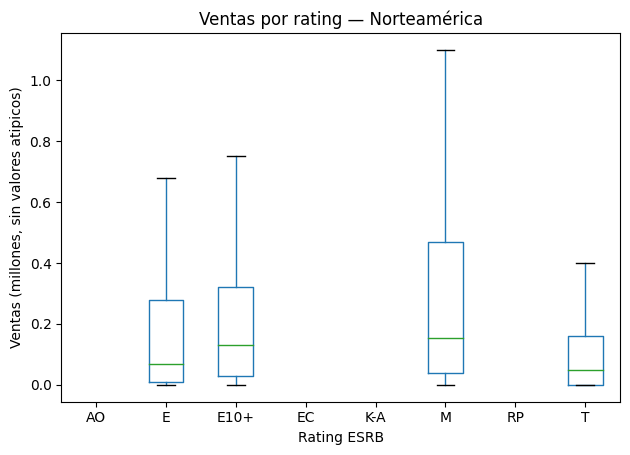

,media,mediana,juegos
rating,,,
M,0.465000,0.155,498
E,0.288388,0.070,397
E10+,0.246623,0.130,308
T,0.160169,0.050,414
AO,NaN,NaN,0
EC,NaN,NaN,0
K-A,NaN,NaN,0
RP,NaN,NaN,0


ANOVA F = 18.39,  p = 9.884e-12
➡︎ Las medias de ventas difieren significativamente entre ratings.

=== Europa ===


<Figure size 700x500 with 0 Axes>

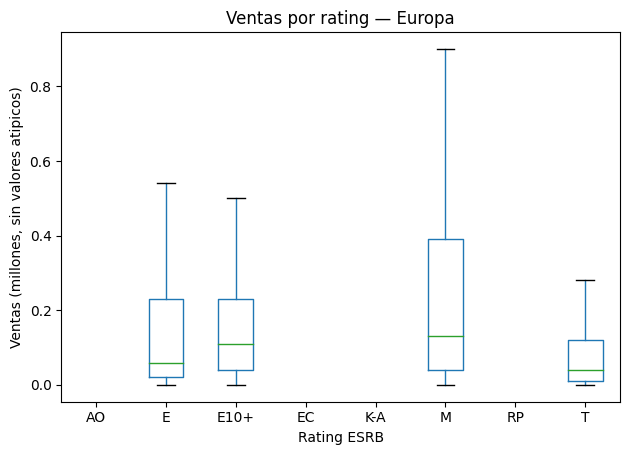

,media,mediana,juegos
rating,,,
M,0.389478,0.13,498
E,0.284761,0.06,397
E10+,0.180390,0.11,308
T,0.128043,0.04,414
AO,NaN,NaN,0
EC,NaN,NaN,0
K-A,NaN,NaN,0
RP,NaN,NaN,0


ANOVA F = 16.98,  p = 7.394e-11
➡︎ Las medias de ventas difieren significativamente entre ratings.

=== Japón ===


<Figure size 700x500 with 0 Axes>

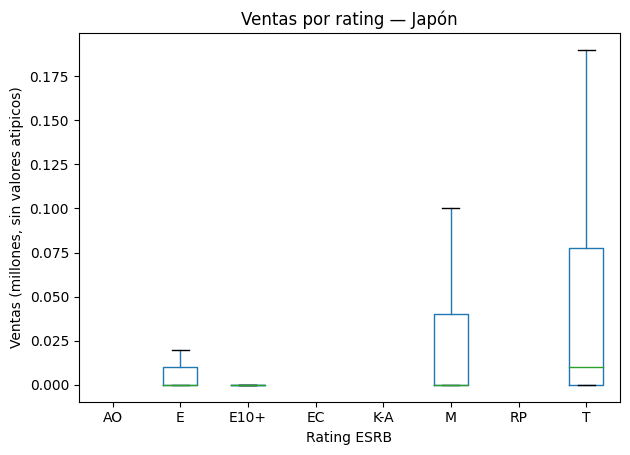

,media,mediana,juegos
rating,,,
E,0.071360,0.00,397
T,0.063019,0.01,414
M,0.042570,0.00,498
E10+,0.026591,0.00,308
AO,NaN,NaN,0
EC,NaN,NaN,0
K-A,NaN,NaN,0
RP,NaN,NaN,0


ANOVA F = 4.18,  p = 5.891e-03
➡︎ Las medias de ventas difieren significativamente entre ratings.


In [31]:
# Función auxiliar: boxplot + tabla + ANOVA para 1 región
def rating_vs_sales(region_col, region_name):
    print(f'\n=== {region_name} ===')

    # Boxplot
    plt.figure(figsize=(7,5))
    df_rate.boxplot(
        column=region_col,
        by='rating',
        grid=False,
        showfliers=False
    )
    plt.title(f'Ventas por rating — {region_name}')
    plt.suptitle('')
    plt.xlabel('Rating ESRB')
    plt.ylabel('Ventas (millones, sin valores atipicos)')
    plt.tight_layout()
    plt.show()

    # Media y mediana por rating
    stats_table = (
        df_rate.groupby('rating')[region_col]
               .agg(media='mean', mediana='median', juegos='count')
               .sort_values('media', ascending=False)
    )
    display(stats_table)

    # ANOVA de Welch (varianzas desiguales)
    groups = [df_rate.loc[df_rate['rating']==r, region_col] for r in cat_keep]
    f_stat, p_val = st.f_oneway(*groups)
    print(f"ANOVA F = {f_stat:.2f},  p = {p_val:.3e}")
    if p_val < 0.05:
        print("➡︎ Las medias de ventas difieren significativamente entre ratings.")
    else:
        print("➡︎ No hay evidencia de diferencias en las medias de ventas.")

rating_vs_sales('na_sales', 'Norteamérica')
rating_vs_sales('eu_sales', 'Europa')
rating_vs_sales('jp_sales', 'Japón')

En mercados occidentales (NA y EU)

Los titulos Mature 17+ concentran el mayor ingreso por juego, shooter AAA como call of duty, juegos de accion y aventura como Elden ring, the witcher, FFVII Remake.
E y E10+, tambien son muy relevantes (FIFA, Mario, juegos de carreras), su media ronda los ~35-40%

El mercado japones es diferente pues todos los ratings vende pocon en comparacion global (la mediana es basicamente cero porque muchos titulos apenas superan las 10000 copias)

Aqui E y T superan ligeramente a Mature (M), esto refleja una realidad de que japon tiene una menor cultura de FPS occidentales y más afinidad por juegos JRPG/juegos de ROL, juegos de cartas, juegos clasicos.

## Paso 5. Prueba las siguientes hipótesis


### Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.

### Hipótesis para la comparación de *user_score* entre **Xbox One** y **PC**

- **Hipótesis nula (H₀)**  

  $$\mu_{\text{XOne}} = \mu_{\text{PC}}$$  

  La calificación promedio de los usuarios es la misma en ambas plataformas.

- **Hipótesis alternativa (H₁)**  

  $$\mu_{\text{XOne}} \ne \mu_{\text{PC}}$$  

  La calificación promedio de los usuarios difiere entre Xbox One y PC.

- **Prueba estadística**: *t-test* de Welch (muestras independientes, varianzas desiguales).

- **Nivel de significancia**: $$(\alpha = 0{,}05)$$.

In [36]:
# Filtra periodo 2012-2016 (o todo, según tu df_recent) y saca user_score válidos
df_score = df_games.dropna(subset=['user_score'])
#print(df_score)

# Función para quitar outliers 1.5×IQR por plataforma
def remove_outliers(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - k*iqr, q3 + k*iqr
    return series[(series >= lower) & (series <= upper)]
    
xone_scores = remove_outliers(df_score.loc[df_score['platform'] == 'XOne', 'user_score'])
pc_scores   = remove_outliers(df_score.loc[df_score['platform'] == 'PC',   'user_score'])

print(f"Xbox One muestras sin valores atipicos: {len(xone_scores)},  PC muestras: {len(pc_scores)}")

# Comprobamos igualdad de varianzas con la prueba de Levene
levene_stat, levene_p = st.levene(xone_scores, pc_scores, center='mean')
alpha = 0.05
print(f"Prueba de Levene - valor p = {levene_p:.3e}")

if levene_p > alpha:
    print("No rechazamos H0 de Levene → asumimos varianzas iguales")
    equal_vars = True
else:
    print("Rechazamos H0 de Levene → varianzas desiguales")
    equal_vars = False

# t‑test independiente usando el resultado de Levene
t_stat, p_val = st.ttest_ind(xone_scores, pc_scores, equal_var=equal_vars)

print(f"\nWelch t‑test (equal_var={equal_vars}) valor p = {p_val:.3e}")

alpha = 0.05
if p_val < alpha:
    print("Rechazamos H₀ → las medias de user_score difieren entre XOne y PC.")
else:
    print("No se rechaza H₀ → no hay evidencia de diferencia en las medias.")

Xbox One muestras sin valores atipicos: 174,  PC muestras: 750
Prueba de Levene - valor p = 1.059e-02
Rechazamos H0 de Levene → varianzas desiguales

Welch t‑test (equal_var=False) valor p = 1.761e-06
Rechazamos H₀ → las medias de user_score difieren entre XOne y PC.


Rechazamos la hipotesis, esto quiere decir que no son iguales las calificaciones de los juegos en PC con respecto a Xbox One, existen muchos juegos que los usuarios califican mejor en PC (por mejor jugabilidad, mas fluidez, planes de pago para jugar online, etc.) y otros prefieren las versiones de consola como con Xbox one.

nota: tambien es importante considerar que las muestras de xbox one son apenas una cuarta parte de las de PC, si tuvieramos mas datos de xbox one nuestra hipotesis podria ser mas certera y menos sesgada a una muestra en especifico.

### Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

- **Hipótesis nula (H₀)**  

  $$\mu_{\text{Acción}} = \mu_{\text{Sports}}$$  

  Las calificaciones promedio de los usuarios son iguales en los géneros Acción y Deportes.

- **Hipótesis alternativa (H₁)**  

  $$\mu_{\text{Acción}} \ne \mu_{\text{Sports}}$$  

  Las calificaciones promedio de los usuarios difieren entre ambos géneros.

- **Prueba estadística** : *t-test* de Welch (dos muestras independientes con varianzas posiblemente distintas).

- **Nivel de significancia** : $$(\alpha = 0{,}05)$$.

In [39]:
# Seleccionamos user_score válidos y los dos géneros
df_score_gen = df_games.dropna(subset=['user_score', 'genre'])

# removemos outliers para evitar sesgos
action_scores  = remove_outliers(df_score_gen.loc[df_score_gen['genre'] == 'Action',  'user_score'])
sports_scores  = remove_outliers(df_score_gen.loc[df_score_gen['genre'] == 'Sports',  'user_score'])

print(f"Acción  (n) sin valores atipicos: {len(action_scores)}")
print(f"Sports  (n) sin valores atipicos: {len(sports_scores)}")

# Prueba de Levene (igualdad de varianzas)
lev_stat, lev_p = st.levene(action_scores, sports_scores, center='mean')
alpha = 0.05
equal_vars = lev_p < alpha   # True si no rechazamos igualdad de varianzas

print(f"Levene  stat={lev_stat:.3f}, p={lev_p:.3e}")
if equal_vars:
    print("Rechazamos H₀ de Levene → usaremos Welch (varianzas desiguales).")
else:
    print("No rechazamos H₀ de Levene → asumimos varianzas iguales.")

# t-test (Welch si equal_vars = False)
t_stat, p_val = st.ttest_ind(action_scores, sports_scores, equal_var=equal_vars)

print(f"Valor p = {p_val:.3e}")

alpha = 0.05
if p_val < alpha:
    print("Rechazamos H₀ → las medias de user_score difieren entre Acción y Deportes.")
else:
    print("No se rechaza H₀ → no hay evidencia de diferencia en las medias.")

Acción  (n) sin valores atipicos: 1777
Sports  (n) sin valores atipicos: 1073
Levene  stat=27.322, p=1.847e-07
Rechazamos H₀ de Levene → usaremos Welch (varianzas desiguales).
Valor p = 9.153e-02
No se rechaza H₀ → no hay evidencia de diferencia en las medias.


No rechazamos la hipotesis por lo que podemos decir que las calificaciones promedio para estos dos generos son similares, no hay diferencia significativa. Al parecer estos dos generos tienden a tener buenas calificaciones en promedio y hace sentido porque como habiamos visto anteriormente estos dos generos son top5 en ventas tanto en NA como en la UE.

## Paso 6. Escribe una conclusión general

### Exploracion y limpieza 
Empezamos explorando y preparando los datos renombrando columnas, imputando datos y adaptando tipos y obtuvimos un dataset limpio, despues hicimos un analisis de las plataformas para obtener al final una captura de los cinco años recientes y detectamos la generacion activa  PS4 / XOne / 3DS / Wii U / PSV.

### Analisis
Detectamos las plataformas lideres en ventas y detectamos en general este patron: PS4 > PS3 > X360 > 3DS > XOne. Mientras que PS4 crece muy rapido, XOne crece mas lento a pesar de ser la plataforma top en USA, 3DS se queda estable, mientras que la Wii U y PSV van en declive.
Tambien detectamos un clico de vida medio de ~7.6 años entre plataformas nuevas y versiones anteriores.

Con esto concluimos que es conveniente Invertir en 2017 en PS4 principal y Xbox One en segunda.

Despues hicimos un analisis de los generos en el que encontramos algunas tendencias y los lideres en ventas Action (440 M) ≫ Shooter (305 M) > RPG > Sports. Media por juego: Shooter (1.29 M) y Sports (0.67 M) son los más rentables individualmente; Adventure, Strategy y Puzzle venden poco.

Para 2017 podria recomendar si se tienen grandes presupuestos, lanzar juegos shooter/action para ps4 y xone en NA y la UE. Pero en Japon es mas recomendable mejor optar por juegos de miscelanea, JRPG, juegos de plataforma lo bueno es que para estos juegos no se requiere un gran presupuesto, aunque es esperable obtener menores ventas en general para cualquier genero comparado con la UE y NA.

Vimos como la critica de los expertos va acorde a las ventas mientras que la de los usuarios varia mucho.
Encontramos una influencia significativa en la categoria ESRB y que los juegos Mature venden mas en NA y UE mientras que en JP lo superan E y T.

Para 2017 podriamos obtener buenas reseñas de profesionales para impulsar las ventas en el "day-one"; el user_score es mas recomendable para mas tarde en posventa (ej: DLCs)

### Hipotesis Estadisticas

Comparamos a Xbox One contra PC por el user_score y encontramos que las medias diferian por lo que alguna de las dos es mayor o menor que la otra, normalmente PC tiene mejores calificaciones.

Tambien comparamos a los generos Action vs Deportes y encontramos que ambas tienden a tener buenas calificaciones y esto nos cuadro con lo que vimos en las ventas como ambos generos lideran el mercado siendo top5.